***In this file, we only focus on the model with 1 and 2 features; and using 6 main method to evaluate then compare them!***

First, I have to note something about this part.

1) In `XGBoost, AdaBoost` we fixed, (and) pick the `learning_rate` = 0.1.

2) In `XGBoost, AdaBoost` and `Random Forest`; we pick the `n_estimators` = 300.

3) In `XGBoost` and `RandomForest`; the `max_depth` = 3

4) The study about the affects of the optimal `learning_rate, n_estimator` and `max_depth` will be considered in the next Session!

5) The 3 last methodologies are `Naive Bayes, Logistic Regression & KNN`

Now, we need import the following `libraries`....

In [16]:
from numpy import loadtxt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd

**Loading dataset**

In [17]:
# load data
df = pd.read_csv(r"train.csv", usecols = ["text", "target"])
df.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


***Checking null-values***

In [18]:
print("col_names : \t" + df.columns)
print('\n')
print("Data-dimensions: \t" + str(df.shape))
print('\n')
print("Count the not-null values of each features: \n" + str(df.notnull().sum()))

Index(['col_names : \ttext', 'col_names : \ttarget'], dtype='object')


Data-dimensions: 	(7613, 2)


Count the not-null values of each features: 
text      7613
target    7613
dtype: int64


***Checking & removing duplications***

In [19]:
df.drop_duplicates(inplace = True)
print("The new dimension after checking duplicate & removing is:\t" + str(df.shape))

The new dimension after checking duplicate & removing is:	(7521, 2)


***Adding variables named Text length & Number of words to get the new model***

In [20]:
df['Text_length'] = df['text'].str.len()
df['Numb_words'] = df['text'].str.split().map(lambda x: len(x))
df.head()

,text,target,Text_length,Numb_words
0,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,Forest fire near La Ronge Sask. Canada,1,38,7
2,All residents asked to 'shelter in place' are ...,1,133,22
3,"13,000 people receive #wildfires evacuation or...",1,65,8
4,Just got sent this photo from Ruby #Alaska as ...,1,88,16


***Define 2 classes: Text_Selector for text-column and Number_Selector for the 2 new features***

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

***Define a `Tokenizer`  function***

In [22]:
import re
from spellchecker import SpellChecker    

def Tokenizer(str_input):
    ## 1. Remove url_link
    remove_url = re.compile(r'https?://\S+|www\.\S+').sub(r'', str_input)
    
    ## 2. Remove html_link
    remove_html = re.compile(r'<.*?>').sub(r'', remove_url)
    
    ## 3. Remove Emojis
    remove_emo = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE).sub(r'', remove_html)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", remove_emo).lower().split()    
        
    ## 4. spell_correction
    # spell = SpellChecker()
    # words = [spell.correction(word) for word in words]

    return words

***Assign X, y to train_test_split & fit the corresponding model***

`We only consider 2 case: ('text' & 'numb_words') and ('text' & 'text_length')`


***`1) Case1. Data contains 'text' & 'numb_words'`***

In [23]:
X = df[['text', 'Numb_words']] 
y = df['target']
test_size = 0.3

**Split dataset into 2 parts: train & test**

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = test_size, 
                                                    stratify = y, 
                                                    random_state = 42)

**Import some libraries**

In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

**1.1. Using AdaBoost_classifier**

In [26]:
classifier1 = Pipeline([
    (
        'features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('text')),
            ('tfidf', TfidfVectorizer(tokenizer = Tokenizer, stop_words = 'english',
                     min_df = .0025, max_df = 0.25, ngram_range = (1, 3) ) ),
            ('svd', TruncatedSVD(algorithm = 'randomized', n_components = 300) ), #for AdaBoost
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('Numb_words')),
            ('wscaler', StandardScaler()),
        ])),            
    ])
    ),
    ('clf', AdaBoostClassifier(n_estimators = 300, learning_rate = 0.1)),
    ])

**Fit the model**

In [28]:
import time
start = time.time()

classifier1.fit(X_train, y_train)
preds = classifier1.predict(X_test)

print ('Fit&trainning time : ', time.time() - start)

Fit&trainning time :  53.046061277389526


**Predict & accuracy**

In [29]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

train_acc_Ada = accuracy_score(y_train, classifier1.predict(X_train)) * 100.0 
test_acc_Ada = accuracy_score(y_test, preds) * 100

print("Training Accuracy: %.2f%%" % train_acc_Ada)
print("Testing Accuracy: %.2f%%" % test_acc_Ada)
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Training Accuracy: 77.36%
Testing Accuracy: 73.99%
Precision: 0.7737226277372263
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1295
           1       0.77      0.55      0.64       962

    accuracy                           0.74      2257
   macro avg       0.75      0.72      0.72      2257
weighted avg       0.75      0.74      0.73      2257

[[1140  155]
 [ 432  530]]


**1.2. Using XGBoost_classifier**

In [40]:
from sklearn.svm import SVC
svc = SVC(probability = True, kernel = 'linear')

from xgboost import XGBClassifier 
classifier1 = Pipeline([
    (
        'features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('text')),
            ('tfidf', TfidfVectorizer(tokenizer = Tokenizer, stop_words = 'english',
                     min_df = .0025, max_df = 0.25, ngram_range = (1, 3) ) ),
            ('svd', TruncatedSVD(algorithm ='randomized', n_components = 300) ), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('Numb_words')),
            ('wscaler', StandardScaler()),
        ])),            
    ])
    ),
    ('clf', XGBClassifier(max_depth = 3, n_estimators = 300, base_estimator = svc, learning_rate = 0.1))
    ])

## Fit the model
start = time.time()
classifier1.fit(X_train, y_train)
preds = classifier1.predict(X_test)
print ('Fit&trainning time : ', time.time() - start)

train_acc_Xgb = accuracy_score(y_train, classifier1.predict(X_train)) * 100.0 
test_acc_Xgb = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_Xgb)
print("Testing_Accuracy: %.2f%%" % test_acc_Xgb)
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Fit&trainning time :  43.873294830322266
Training_Accuracy: 89.87%
Testing_Accuracy: 76.65%
Precision: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1295
           1       0.78      0.63      0.70       962

    accuracy                           0.77      2257
   macro avg       0.77      0.75      0.75      2257
weighted avg       0.77      0.77      0.76      2257

[[1121  174]
 [ 353  609]]


**1.3. Using RandomForest_classifier**

In [41]:
from sklearn.ensemble import RandomForestClassifier

classifier1 = Pipeline([
    (
        'features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('text')),
            ('tfidf', TfidfVectorizer(tokenizer = Tokenizer, stop_words = 'english',
                     min_df = .0025, max_df = 0.25, ngram_range = (1, 3) ) ),
            ('svd', TruncatedSVD(algorithm ='randomized', n_components = 300) ), 
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('Numb_words')),
            ('wscaler', StandardScaler()),
        ])),            
    ])
    ),
    ('clf', RandomForestClassifier(max_depth = 3, n_estimators = 300)),
    ])

start = time.time()
classifier1.fit(X_train, y_train)
preds = classifier1.predict(X_test)
print ('Fit&trainning time : ', time.time() - start)

train_acc_RFC = accuracy_score(y_train, classifier1.predict(X_train)) * 100.0
test_acc_RFC = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_RFC )
print("Testing_Accuracy: %.2f%%" % test_acc_RFC )
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Fit&trainning time :  6.828919887542725
Training_Accuracy: 71.11%
Testing_Accuracy: 69.03%
Precision: 0.8168674698795181
              precision    recall  f1-score   support

           0       0.66      0.94      0.78      1295
           1       0.82      0.35      0.49       962

    accuracy                           0.69      2257
   macro avg       0.74      0.65      0.63      2257
weighted avg       0.73      0.69      0.66      2257

[[1219   76]
 [ 623  339]]


**1.4. Using NaiveBayes**

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
text_process = CountVectorizer(analyzer = Tokenizer).fit_transform(df['text'])


from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(text_process, df['target'], 
                                                    test_size = test_size, 
                                                    stratify = df['target'], 
                                                    random_state = 42)

classifier1 = MultinomialNB()
classifier1.fit(X_train, y_train)
preds = classifier1.predict(X_test)

train_acc_NVB = accuracy_score(y_train, classifier1.predict(X_train)) * 100.0
test_acc_NVB = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_NVB)
print("Testing_Accuracy: %.2f%%" % test_acc_NVB)
print(classification_report(y_test, preds))
print('Confusion Matrix: \n',confusion_matrix(y_test, preds))

Training_Accuracy: 90.44%
Testing_Accuracy: 79.26%
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1295
           1       0.78      0.71      0.74       962

    accuracy                           0.79      2257
   macro avg       0.79      0.78      0.78      2257
weighted avg       0.79      0.79      0.79      2257

Confusion Matrix: 
 [[1108  187]
 [ 281  681]]


**1.5) Using Logistic Regression**

In [43]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], 
                                                    stratify = df['target'],
                                                    test_size = test_size, 
                                                    random_state = 42)


# Initialize the tfidf_vectorizer 
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7) 

# Fit and transform the training data to Tfidf_Vec
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Fit the model
C = 0.1
classifier1 = LogisticRegression(random_state = 42, C = C).fit(tfidf_train, y_train)

preds = classifier1.predict(tfidf_test)

train_acc_logreg = accuracy_score(y_train, classifier1.predict(tfidf_train)) * 100.0
test_acc_logreg = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_logreg)
print("Testing_Accuracy: %.2f%%" % test_acc_logreg)
print(classification_report(y_test, preds))
print('Confusion Matrix: \n', confusion_matrix(y_test, preds))

Training_Accuracy: 71.14%
Testing_Accuracy: 70.93%
              precision    recall  f1-score   support

           0       0.67      0.96      0.79      1295
           1       0.88      0.37      0.52       962

    accuracy                           0.71      2257
   macro avg       0.78      0.67      0.66      2257
weighted avg       0.76      0.71      0.68      2257

Confusion Matrix: 
 [[1248   47]
 [ 609  353]]


/Users/loctran/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**1.6) Using KNN**

In [46]:
%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 100)
classifier1 = knn.fit(tfidf_train, y_train)

preds = knn.predict(tfidf_test)

train_acc_knn = accuracy_score(y_train, knn.predict(tfidf_train)) * 100.0
test_acc_knn = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_knn)
print("Testing_Accuracy: %.2f%%" % test_acc_knn)
print(classification_report(y_test, preds))
print('Confusion Matrix: \n', confusion_matrix(y_test, preds))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
Training_Accuracy: 78.38%
Testing_Accuracy: 76.92%
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1295
           1       0.80      0.62      0.69       962

    accuracy                           0.77      2257
   macro avg       0.78      0.75      0.75      2257
weighted avg       0.77      0.77      0.76      2257

Confusion Matrix: 
 [[1143  152]
 [ 369  593]]


**Summary 1.** With the model contains 2 features `'text'` and `'number of words'`

In [47]:
train_acc = [train_acc_Ada, train_acc_Xgb, train_acc_RFC, train_acc_NVB, train_acc_logreg, train_acc_knn]
test_acc = [test_acc_Ada, test_acc_Xgb, test_acc_RFC, test_acc_NVB, test_acc_logreg, test_acc_knn]
method = ['AdaBoost', 'XGBoost', 'RandomForest', 'Naive_Bayes', 'Logistic_Regression', 'k-NN']

model1 = pd.DataFrame({'train_acc(%)': train_acc,
                       'test_acc(%)' : test_acc,
                       'used_method': method})
model1

,train_acc(%),test_acc(%),used_method
0,77.355623,73.992025,AdaBoost
1,89.874620,76.650421,XGBoost
2,71.105623,69.029685,RandomForest
3,90.444529,79.264510,Naive_Bayes
4,71.143617,70.934869,Logistic_Regression
5,78.381459,76.916261,k-NN


**`2) Case2. Data contains 'text' & 'text_length'`**

`So the first step in this case is assign X, y again to the new columns_names`

In [48]:
X = df[['text', 'Text_length']] 
y = df['target']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    stratify = y, 
                                                    random_state = 42)

**2.1. AdaBoost**

In [49]:
classifier2 = Pipeline([
    (
        'features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('text')),
            ('tfidf', TfidfVectorizer(tokenizer = Tokenizer, stop_words = 'english',
                     min_df = .0025, max_df = 0.25, ngram_range = (1, 3) ) ),
            ('svd', TruncatedSVD(algorithm ='randomized', n_components = 300) ), 
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('Text_length')),
            ('wscaler', StandardScaler()),
        ])),            
    ])
    ),
    ('clf', AdaBoostClassifier(n_estimators = 300, learning_rate = 0.01)),
    ])

start = time.time()
classifier2.fit(X_train, y_train)
preds = classifier2.predict(X_test)
print('Fit&trainning time : ', time.time() - start)

train_acc_Ada2 = accuracy_score(y_train, classifier2.predict(X_train)) * 100.0
test_acc_Ada2 = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_Ada2)
print("Testing_Accuracy: %.2f%%" % test_acc_Ada2)
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Fit&trainning time :  61.38667297363281
Training_Accuracy: 69.55%
Testing_Accuracy: 68.37%
Precision: 0.718421052631579
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       863
           1       0.72      0.43      0.53       642

    accuracy                           0.68      1505
   macro avg       0.70      0.65      0.65      1505
weighted avg       0.69      0.68      0.66      1505

[[756 107]
 [369 273]]


**2.2. XGBoost**

In [50]:
from sklearn.svm import SVC
svc = SVC(probability = True, kernel = 'linear')

from xgboost import XGBClassifier 
classifier2 = Pipeline([
    (
        'features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('text')),
            ('tfidf', TfidfVectorizer(tokenizer = Tokenizer, stop_words = 'english',
                     min_df = .0025, max_df = 0.25, ngram_range = (1, 3) ) ),
            ('svd', TruncatedSVD(algorithm ='randomized', n_components = 300) ), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('Text_length')),
            ('wscaler', StandardScaler()),
        ])),            
    ])
    ),
    ('clf', XGBClassifier(max_depth = 3, n_estimators = 300, base_estimator = svc, learning_rate = 0.1))
    ])

## Fit the model
start = time.time()
classifier2.fit(X_train, y_train)
preds = classifier2.predict(X_test)
print ('Fit&trainning time : ', time.time() - start)

train_acc_Xgb2 = accuracy_score(y_train, classifier2.predict(X_train)) * 100.0 
test_acc_Xgb2 = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_Xgb2)
print("Testing_Accuracy: %.2f%%" % test_acc_Xgb2)
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Fit&trainning time :  51.36156702041626
Training_Accuracy: 89.11%
Testing_Accuracy: 77.74%
Precision: 0.7806215722120659
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       863
           1       0.78      0.67      0.72       642

    accuracy                           0.78      1505
   macro avg       0.78      0.76      0.77      1505
weighted avg       0.78      0.78      0.77      1505

[[743 120]
 [215 427]]


**2.3. Random Forest**

In [51]:
from sklearn.ensemble import RandomForestClassifier

classifier2 = Pipeline([
    (
        'features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('text')),
            ('tfidf', TfidfVectorizer(tokenizer = Tokenizer, stop_words = 'english',
                     min_df = .0025, max_df = 0.25, ngram_range = (1, 3) ) ),
            ('svd', TruncatedSVD(algorithm ='randomized', n_components = 300) ), 
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('Text_length')),
            ('wscaler', StandardScaler()),
        ])),            
    ])
    ),
    ('clf', RandomForestClassifier(max_depth = 3, n_estimators = 300)),
    ])

start = time.time()
classifier2.fit(X_train, y_train)
preds = classifier2.predict(X_test)
print ('Fit&trainning time : ', time.time() - start)

train_acc_RFC2 = accuracy_score(y_train, classifier2.predict(X_train)) * 100.0
test_acc_RFC2 = accuracy_score(y_test, preds) * 100.0

print("Training_Accuracy: %.2f%%" % train_acc_RFC2 )
print("Testing_Accuracy: %.2f%%" % test_acc_RFC2 )
print("Precision:", precision_score(y_test, preds))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Fit&trainning time :  7.723005056381226
Training_Accuracy: 72.32%
Testing_Accuracy: 71.30%
Precision: 0.8322784810126582
              precision    recall  f1-score   support

           0       0.68      0.94      0.79       863
           1       0.83      0.41      0.55       642

    accuracy                           0.71      1505
   macro avg       0.76      0.67      0.67      1505
weighted avg       0.75      0.71      0.69      1505

[[810  53]
 [379 263]]


Noting that in 3 last methods (`NaiveBayes, Logistic Regression & K nearest neighbor`); we only consider only the `'text'` feature and ignored `'numb_words'` also `'text_length'`

In [52]:
train_acc = [train_acc_Ada2, train_acc_Xgb2, train_acc_RFC2, train_acc_NVB, train_acc_logreg, train_acc_knn]
test_acc = [test_acc_Ada2, test_acc_Xgb2, test_acc_RFC2, test_acc_NVB, test_acc_logreg, test_acc_knn]
method = ['AdaBoost', 'XGBoost', 'RandomForest', 'Naive_Bayes', 'Logistic_Regression', 'k-NN']

model2 = pd.DataFrame({'train_acc(%)': train_acc,
                       'test_acc(%)' : test_acc,
                       'used_method': method})
model2

,train_acc(%),test_acc(%),used_method
0,69.547872,68.372093,AdaBoost
1,89.112367,77.740864,XGBoost
2,72.323803,71.295681,RandomForest
3,90.444529,79.264510,Naive_Bayes
4,71.143617,70.934869,Logistic_Regression
5,78.381459,76.916261,k-NN


# Deep Learning

In [53]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [54]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [55]:
import nltk
import string
import re
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
def clean_text_NGram(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    token = re.split('\W+',text)
    text = " ".join([ps.stem(word) for word in token if word not in stopwords])
    return text

In [56]:
df['cleaned_text_NGram']= df['text'].apply(lambda x: clean_text_NGram(x))
df.head()

,id,keyword,location,text,target,cleaned_text_NGram
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order califor...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [57]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index

vocab_size=len(word_index)
print(vocab_size)
#word_index.items()

22700


In [58]:
df['text_len'] = df['text'].apply(lambda x: len(x) - x.count(" "))
print(df['text'][2])
df['text_len'].head()

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


0     57
1     32
2    112
3     57
4     72
Name: text_len, dtype: int64

In [59]:
# Padding data

max_len = 32
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print('sequences: ',sequences[0:5])
print('padded: ',padded[0:5])

sequences:  [[119, 4633, 24, 4, 868, 8, 21, 263, 138, 1619, 4634, 89, 40], [189, 45, 229, 799, 6954, 6955, 1404], [40, 1751, 1620, 7, 6956, 6, 6957, 24, 136, 6958, 20, 1752, 39, 441, 256, 57, 2158, 6, 714, 1405, 24, 1106], [835, 2921, 59, 4635, 1500, 256, 1405, 6, 96], [34, 100, 1221, 21, 320, 22, 6959, 2159, 30, 271, 22, 1500, 6960, 69, 5, 187]]
padded:  [[ 119 4633   24    4  868    8   21  263  138 1619 4634   89   40    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 189   45  229  799 6954 6955 1404    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  40 1751 1620    7 6956    6 6957   24  136 6958   20 1752   39  441
   256   57 2158    6  714 1405   24 1106    0    0    0    0    0    0
     0    0    0    0]
 [ 835 2921   59 4635 1500  256 1405    6   96    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   

In [60]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['target'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['target'].values[split_n:]

# Deep Learning model
**Input instance:** $x \in \mathbb{N}^{32}$.  
**The following code generates** ```embeddings_matrix``` ($E$) whose each row $\in \mathbb{R}^{200}$ representing one word of ```word_index```. 

**The embedding layer** will take this matrix as its initial weight. 


In [61]:
# Import tensor representations for words
embeddings_index = {};
embedding_dim =200
with io.open('glove.6B.200d.txt',encoding='utf8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

200


# The model (LSTM + Conv1D + MaxPooling1D + Dropout + Dense)

In [ ]:
# Build the architecture of the model
     
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size+1,embedding_dim, weights=[embeddings_matrix], trainable=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=4),
#     tf.keras.layers.LSTM(20, return_sequences=True),
#     tf.keras.layers.LSTM(20),
#     tf.keras.layers.Dropout(0.2),  
#     tf.keras.layers.Dense(512),
#     tf.keras.layers.Dropout(0.3),  
#     tf.keras.layers.Dense(256),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len,weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# The layers

In [70]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 200)           4540200   
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 32)            27776     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                2624      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

## Embedding layers:
**Code:** 
``` python
tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len,weights=[embeddings_matrix], trainable=False)
```

**Notations:**
-  our data has ```vocab_size``` (22700) number of words.
- Each input sentence is padded into a sequence of ```max_len```(32) words.
- Each word is embedded into a ```embedding_dim```(200) dimensional vector.
 
**Formulation:** $$x \in \mathbb{N}^{32} \to \hat x \to \hat x E \in \mathbb{R}^{32\times 200}$$ 
where:
- $\hat x \in \{0, 1\}^{32\times \mbox{vocab_size}}$ is the **one hot** encoding of $x \in \mathbb{N}^{32}$. 
- $E \in \mathbb{R}^{\mbox{vocab_size}\times 200}$ is the ```embeddings_matrix```.

**We don't train this layer.**


## Conv1D (not included in our model)
**Code:**
```python
tf.keras.layers.Conv1D(64, 5, activation='relu')
```
**Parameters:**
- 64 filters
- 5 is the kernel size (5x1)
- by default stride = 1

**Formulation:**
$$
x \in \mathbb{R}^{32 \times 200} \to x\mbox{*} K_{5} \to \mbox{ReLU}(x\mbox{*} K_{5}+b) \in \mathbb{R}^{64\times (32 - 5 + 1)\times 200}
$$
where 
- $K_5$ are $64$ filters of size $5$
- $b_i \in \mathbb{R}$

## Bidirectional layer
**Code:** 
```python
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True))
```
**parameters:**
- ```16```: number of units of LSTM perceptrons.
- ```return_sequences=True```: return $(y_1, y_2, ..., y_{32})$. When ```python False```, only return $y_{32}$. 

**Formulation of each of ```16``` units of LSTM:**

- Input: $x  = (x_1, x_2, ..., x_{32})\in \mathbb{R}^{32x200}$.
- Output:  $y  = (y_1, y_2, ..., y_{16})\in \mathbb{R}^{16}$.

![image](bidirectional.png)

- Algorithm:
$$
a = (a_1, ..., a_{32}) = LSTM_1(x)\\
a' = (a'_1, ..., a'_{32}) = \overleftarrow{LSTM_2(\overleftarrow{x})}\\
\mbox{output} =([a_i, a_i'])_{i\in \{1, ..., 32 \}} \in \mathbb{R}^{2\times 32}
%y = (y_1, ..., y_{32}) = (\tanh(W^{[i]}_y[a_i, a'_i] + b_y^{[i]}))_{i\in \{1,.., 32\}}
$$


## Dropout Layer
**Code:**
```python
tf.keras.layers.Dropout(0.15)
```
**Parameters:**
- ```0.15```: dropout rate 

**Algorithm**
- Input: $x \in \mathbb{R}^4$
- Output: $y \in \mathbb{R}^4$
- Algorithm: 
$$
y = x::R = (x_1 R_1, x_2 R_2, x_3 R_3, x_4 R_4),
$$ 
where $R: \Omega \to \{0, 1\}^{4}$ is a random variable with $P(R_i = 0) = 0.15$. 

**This layer is not trainable.**


## Training
**Code**
```python
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
```

**Binary cross-entropy loss function**
$$
L_i = -\left[y_i\ln(\hat y_i) + (1-y_i)\ln(1-\hat y_i)\right]
$$

**If we'd used weight_decay with rate ```wd```**, the loss function would have been
$$
L_i = -\left[y_i\ln(\hat y_i) + (1-y_i)\ln(1-\hat y_i)\right] + \mbox{wd} \sum_{w}|w|^2
$$

**Adam Optimizer**
Detailed explainations and intuition are presented in this [post](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c)

\begin{align}
   & \beta_1 = 0.9, \mbox{ and } \beta_2 = 0.999\\
   & g_t = \nabla_{w} L\\
   % m_0 = 0
   & m_t = \beta_1 * m_{t-1} + (1 - \beta_1) * g_t\\
   & v_t = \beta_2 * v_{t-1} + (1 - \beta_2) * |g|^2\\
   & \hat m_t = \frac{m_{t}}{1 - \beta_1^t}\\
   & \hat v_t = \frac{v_{t}}{1 - \beta_2^t}\\
   & w_t = w_{t-1} - \mbox{lr} \frac{\hat m_t}{\sqrt{\hat v_t}+ \epsilon}
\end{align}

In [ ]:
history = model.fit(train_data, train_labels, epochs=20, batch_size=100, validation_data=[test_data, test_labels])

print("Training Complete")

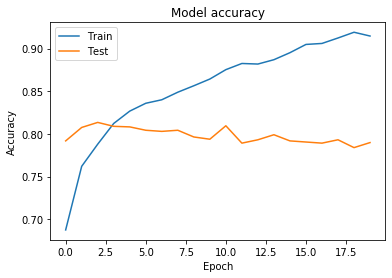

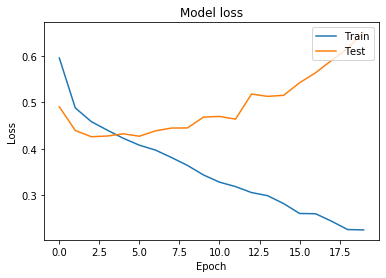

In [64]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('loss.png')
plt.show()
